# Making all trains and test similar and compatible

Rework of [this](2022-03-19_train-test_comparison.ipynb) notebook

## imports and reading data

In [1]:
from warnings import filterwarnings
from datetime import datetime

import re
import json
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lib.data_viz_functions import *

filterwarnings("ignore")
sns.set()

## reading raw data

In [2]:
train_jane = pd.read_pickle("data/train_df_full_part1.pkl.zip", compression="zip")
train_sokolov = pd.read_pickle("data/all_auto_ru_09_09_2020.pkl.zip", compression="zip")
test = pd.read_pickle("data/test.pkl.zip", compression="zip")

## viewing NAs

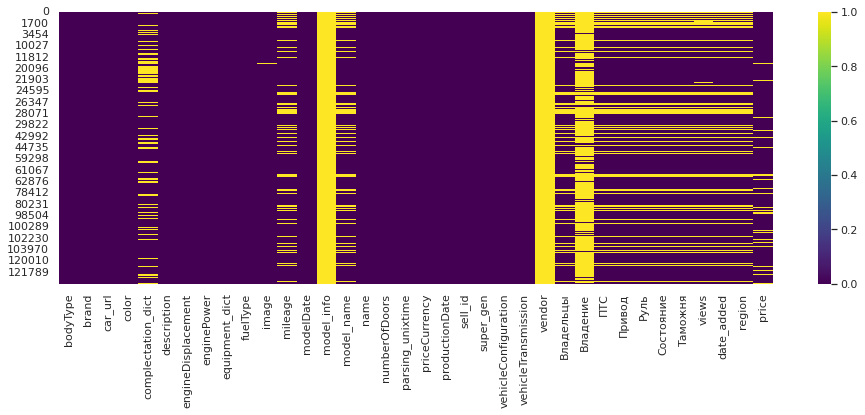

In [3]:
plt.figure(figsize=(16, 5))
sns.heatmap(train_jane.drop_duplicates(subset=["car_url"]).isna(), cmap="viridis")
plt.show()

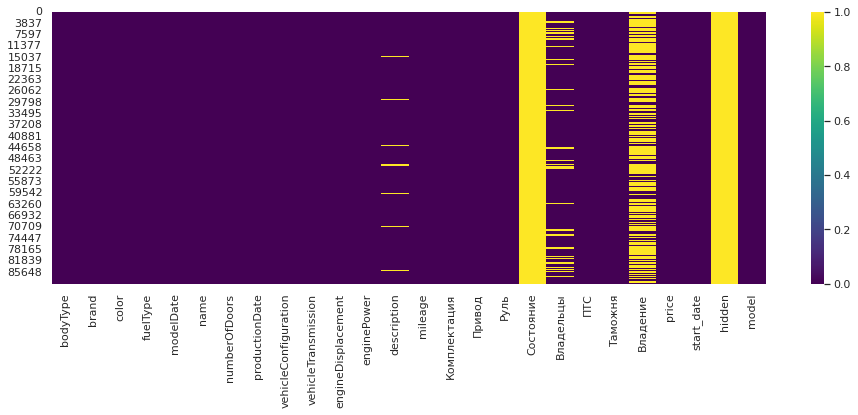

In [4]:
plt.figure(figsize=(16, 5))
sns.heatmap(train_sokolov.drop_duplicates().isna(), cmap="viridis")
plt.show()

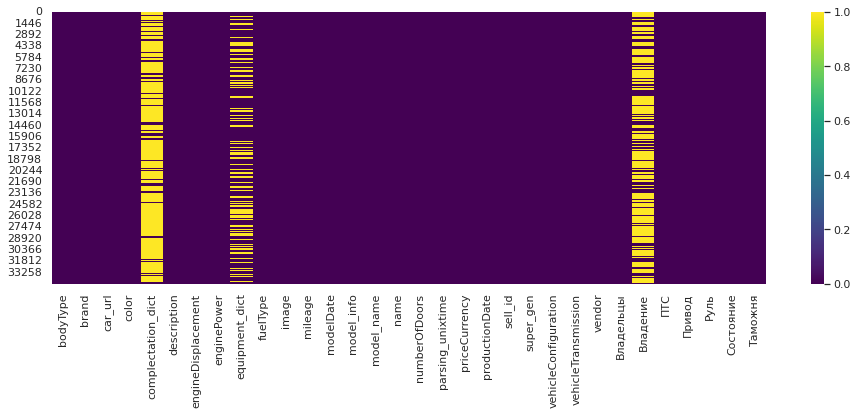

In [5]:
plt.figure(figsize=(16, 5))
sns.heatmap(test.drop_duplicates(subset=["car_url"]).isna(), cmap="viridis")
plt.show()

## functions and vocs for preprocessing

In [6]:
colors_dict = {
    "040001": "чёрный",
    "EE1D19": "красный",
    "0000CC": "синий",
    "CACECB": "серый",
    "007F00": "зелёный",
    "FAFBFB": "белый",
    "97948F": "серый",
    "22A0F8": "синий",
    "660099": "фиолетовый",
    "200204": "коричневый",
    "C49648": "коричневый",
    "DEA522": "золотистый",
    "4A2197": "фиолетовый",
    "FFD600": "жёлтый",
    "FF8649": "оранжевый",
    "FFC0CB": "розовый",
}

vendor_voc_additional = {
    "CADILLAC": "AMERICAN",
    "CHERY": "CHINESE",
    "CHEVROLET": "AMERICAN",
    "CHRYSLER": "AMERICAN",
    "CITROEN": "EUROPEAN",
    "DAEWOO": "KOREAN",
    "DODGE": "AMERICAN",
    "FORD": "AMERICAN",
    "GEELY": "CHINESE",
    "HYUNDAI": "KOREAN",
    "JAGUAR": "EUROPEAN",
    "JEEP": "AMERICAN",
    "KIA": "KOREAN",
    "MAZDA": "JAPANESE",
    "MINI": "EUROPEAN",
    "OPEL": "EUROPEAN",
    "PEUGEOT": "EUROPEAN",
    "PORSCHE": "EUROPEAN",
    "RENAULT": "EUROPEAN",
    "SUBARU": "JAPANESE",
    "SUZUKI": "JAPANESE",
    "GREAT_WALL": "CHINESE",
    "LAND_ROVER": "EUROPEAN",
    "SSANG_YONG": "KOREAN",
}

transmission_dict = {
    "роботизированная": "ROBOT",
    "автоматическая": "AUTOMATIC",
    "механическая": "MECHANICAL",
    "вариатор": "VARIATOR",
}

In [7]:
def parse_ownership_duration(train_str: str) -> int:
    """
    Processing "Владение" column
    Returns ownership duration in days (integer)
    """
    baseline_str = "{'year': 2020, 'month': 9}"
    if not isinstance(train_str, str):
        return np.nan
    elif "year" in str(train_str):
        baseline_dict = json.loads(baseline_str.replace("'", '"'))
        train_dict = json.loads(train_str.replace("'", '"'))
        baseline_date = datetime.strptime(
            f"{baseline_dict['year']}-{baseline_dict['month']}-1", "%Y-%m-%d"
        )
        train_date = datetime.strptime(
            f"{train_dict['year']}-{train_dict['month']}-1", "%Y-%m-%d"
        )
        return (baseline_date - train_date).days
    elif " и " in str(train_str):
        return (
            int(train_str.split(" ")[0]) * 365
            + int(train_str.split(" и ")[1].split(" ")[0]) * 30
        )
    else:
        return int(train_str.split(" ")[0]) * 365


def get_number_of_owners_from_owners(in_str):
    """
    Processing "Владельцы" column
    Extracting numbers from text
    """
    if not isinstance(in_str, str):
        return None
    else:
        result = in_str.replace("\xa0", "")
        return int(re.sub("\D", "", result))


def get_volume_from_vehicleConfiguration(in_str: str) -> str:
    """
    Processing "engineDisplacement"
    Extracting numbers but resurns as str: to convers using .astype method after
    """
    if not pd.isna(in_str):
        if 'electro' in in_str.lower():
            return np.nan
        else:
            engine_volume = re.findall("[\d]*[.][\d]+", in_str)
            if len(engine_volume) >= 1:
                return engine_volume[0]
            else:
                return np.nan
    else:
        return np.nan


def standart_model_name(in_str):
    if not pd.isna(in_str):
        in_str = in_str.upper()
        in_str = in_str.replace('-', '_')
        in_str = in_str.replace(' ', '_')
        in_str = in_str.replace('_СЕРИИ', 'ER')
        in_str = in_str.replace('_КЛАСС', '_KLASSE')
        in_str = in_str.replace('RAV4', 'RAV_4')
        in_str = in_str.replace('190_(W201)', 'W201')
        return in_str

## cleanup start

### NaN's, duplicated and new cars cleanup

In [8]:
# drop rows with NaN's in price
train_jane.dropna(subset=["price"], inplace=True)

# drop rows with duplicates in 'car_url' columns
train_jane.drop_duplicates(subset='car_url', inplace=True)

# drop rows with new cars ads 
mask_new_cars = train_jane['car_url'].str.contains('new')
train_jane.drop(train_jane[mask_new_cars].index, inplace=True)

train_jane.reset_index(drop=True, inplace=True)

### enginePower, engineDisplacement and name

In [9]:
train_jane["enginePower"] = train_jane["enginePower"].replace("undefined N12", None)
train_jane["enginePower"] = (
    train_jane[~pd.isna(train_jane["enginePower"])]["enginePower"]
    .str.split()
    .str.get(0)
    .astype("int")
)

In [10]:
test["enginePower"] = test["enginePower"].replace("undefined N12", None)
test["enginePower"] = (
    test[~pd.isna(test["enginePower"])]["enginePower"]
    .str.split()
    .str.get(0)
    .astype("int")
)

In [11]:
train_jane["engineDisplacement"] = train_jane["engineDisplacement"].replace(
    " LTR", None
)
train_jane["engineDisplacement"] = (
    train_jane[~pd.isna(train_jane["engineDisplacement"])]["engineDisplacement"]
    .str.split()
    .str.get(0)
    .astype("float")
)

In [12]:
train_sokolov["engineDisplacement"] = (
    train_sokolov["name"].apply(get_volume_from_vehicleConfiguration).astype("float64")
)

In [13]:
test["engineDisplacement"] = test["engineDisplacement"].replace(" LTR", None)
test["engineDisplacement"] = (
    test[~pd.isna(test["engineDisplacement"])]["engineDisplacement"]
    .str.split()
    .str.get(0)
    .astype("float")
)

In [14]:
test["Владельцы"] = test["Владельцы"].apply(get_number_of_owners_from_owners)
train_jane["Владельцы"] = train_jane["Владельцы"].apply(
    get_number_of_owners_from_owners
)

In [15]:
train_jane["model_name"] = train_jane.model_name.apply(
    lambda x: x.upper() if not pd.isna(x) else x
)
test["model_name"] = test.model_name.apply(lambda x: x.upper() if not pd.isna(x) else x)

In [16]:
brand_set = set(train_jane['brand'].unique()) | set(train_sokolov['brand'].unique()) | set(test['brand'].unique())

### model_name

In [17]:
for brand in brand_set:
    all_models = (
        set(train_jane.dropna(subset='model_name')[train_jane['brand'] == brand]['model_name'].unique()) | 
        set(train_sokolov.dropna(subset='model')[train_sokolov['brand'] == brand]['model'].unique()) | 
        set(test.dropna(subset='model_name')[test['brand'] == brand]['model_name'].unique())
    )
    print(sorted(all_models))

['CABRIO', 'CLUBMAN', 'COUNTRYMAN', 'COUPE', 'HATCH', 'PACEMAN']
['AEROSTAR', 'BRONCO', 'CONTOUR', 'CORTINA', 'COUGAR', 'CROWN_VICTORIA', 'C_MAX', 'ECONOLINE', 'ECOSPORT', 'EDGE', 'ESCAPE', 'ESCORT', 'EXCURSION', 'EXPEDITION', 'EXPLORER', 'EXPLORER_SPORT_TRAC', 'FESTIVA', 'FIESTA', 'FIESTA_ST', 'FOCUS', 'FOCUS_NA', 'FOCUS_RS', 'FOCUS_ST', 'FREDA', 'FREESTYLE', 'FUSION', 'FUSION_NA', 'F_150', 'GALAXY', 'GRANADA', 'KA', 'KUGA', 'LASER', 'LTD_CROWN_VICTORIA', 'MAVERICK', 'MODEL_A', 'MODEL_T', 'MONDEO', 'MONDEO_ST', 'MUSTANG', 'ORION', 'PROBE', 'RANGER', 'SCORPIO', 'SIERRA', 'S_MAX', 'TAUNUS', 'TAURUS', 'THUNDERBIRD', 'TOURNEO_CONNECT', 'TOURNEO_CUSTOM', 'V8', 'WINDSTAR', 'ZEPHYR']
['EX', 'FX', 'G', 'G35', 'I', 'JX', 'M', 'Q', 'Q30', 'Q50', 'Q60', 'Q70', 'QX30', 'QX4', 'QX50', 'QX56', 'QX60', 'QX70', 'QX80']
['AMULET', 'ARRIZO7', 'BONUS', 'BONUS_3', 'CROSS_EASTAR', 'FORA', 'INDIS', 'KIMO', 'M11', 'ORIENTAL_SON', 'QQ', 'QQ6', 'TIGGO', 'TIGGO_2', 'TIGGO_3', 'TIGGO_4', 'TIGGO_5', 'TIGGO_7', '

In [18]:
train_jane['model_name'] = train_jane['model_name'].apply(standart_model_name)
test['model_name'] = test['model_name'].apply(standart_model_name)

In [19]:
for brand in train_jane['brand'].unique():
    print(train_jane[train_jane['brand'] == brand]['model_name'].unique())

['OCTAVIA' 'RAPID' 'YETI' 'SUPERB' 'KODIAQ' 'ROOMSTER' 'FABIA' 'KAROQ'
 'FELICIA' 'OCTAVIA_RS' 'FABIA_RS' 'FAVORIT' '105,_120']
['A7' 'A8' 'A6' 'Q3' 'Q5' 'A5' 'Q7' 'A4' 'TT' 'A3' 'S8' 'SQ7' 'RS_5' '80'
 'Q8' 'RS_Q3' 'A6_ALLROAD' 'A1' 'A4_ALLROAD' 'S4' '100' '200' 'SQ8' 'A2'
 'RS_6' 'RS_3' 'SQ5' 'Q3_SPORTBACK' 'TT_RS' 'RS_7' 'S6' 'S5' 'E_TRON'
 'TTS' 'R8' 'E_TRON_SPORTBACK' 'V8' 'RS_E_TRON_GT' 'Q5_SPORTBACK' '90'
 'RS_4' 'S1' 'S7' 'COUPE' 'S3']
['CR_V' 'CIVIC' 'ORTHIA' 'JAZZ' 'FIT' 'PILOT' 'FREED' 'ACCORD' 'STREAM'
 'ZEST' 'HR_V' 'N_WGN' 'STEPWGN' 'LEGEND' 'VEZEL' 'ODYSSEY' 'CAPA'
 'INTEGRA' 'SHUTTLE' 'FIT_ARIA' 'CIVIC_TYPE_R' 'INSIGHT' 'SABER' 'PRELUDE'
 'ELEMENT' 'AIRWAVE' 'PARTNER' 'CROSSTOUR' 'TORNEO' 'N_BOX' 'LOGO'
 'MOBILIO' 'ODYSSEY_(NORTH_AMERICA)' 'CIVIC_FERIO' 'CROSSROAD' 'FR_V'
 'S660' 'DOMANI' 'INSPIRE' 'FIT_SHUTTLE' 'CITY' 'JADE' 'GRACE' 'LIFE'
 'ASCOT' 'ELYSION' 'EDIX' 'AVANCIER' 'MOBILIO_SPIKE' 'INTEGRA_SJ'
 'CLARITY' 'TODAY' 'N_ONE' 'S2000' 'CR_Z' 'RIDGELINE' 'VIGOR' 'CR

In [20]:
for brand in train_sokolov['brand'].unique():
    print(train_sokolov[train_sokolov['brand'] == brand]['model'].unique())

['100' '200' '80' '90' '920' 'A1' 'A2' 'A3' 'A4' 'A4_ALLROAD' 'A5' 'A6'
 'ALLROAD' 'A7' 'A8' 'COUPE' 'E_TRON' 'Q3' 'Q3_SPORTBACK' 'Q5' 'Q7' 'Q8'
 'R8' 'RS3' 'RS4' 'RS5' 'RS6' 'RS7' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'SQ5'
 'TT' 'TT_RS' 'TTS' 'V8']
['02' '1ER' 'M1' '2ER' '2ACTIVETOURER' '2GRANDTOURER' '3ER' '321' '326'
 '340' '4' '5ER' '6ER' '7ER' '8ER' 'E3' 'I3' 'I8' 'M2' 'M3' 'M4' 'M5' 'M6'
 'M8' 'X1' 'X2' 'X3' 'X3_M' 'X4' 'X5' 'X5_M' 'X6' 'X6_M' 'X7' 'Z1' 'Z3'
 'Z3M' 'Z4']
['ATS' 'BLS' 'CATERA' 'CT6' 'CTS' 'CTS_V' 'DE_VILLE' 'ELDORADO' 'ESCALADE'
 'FLEETWOOD' 'SEVILLE' 'SRX' 'STS' 'XT5' 'XT6']
['AMULET' 'ARRIZO7' 'BONUS' 'BONUS_3' 'CROSS_EASTAR' 'FORA' 'INDIS' 'KIMO'
 'M11' 'ORIENTAL_SON' 'QQ6' 'QQ' 'TIGGO' 'TIGGO_2' 'TIGGO_3' 'TIGGO_4'
 'TIGGO_5' 'TIGGO_7' 'VERY']
['ALERO' 'ASTRO' 'AVALANCHE' 'AVEO' 'BEL_AIR' 'BLAZER' 'K5_BLAZER' 'CK'
 'CAMARO' 'CAPRICE' 'CAPTIVA' 'CAVALIER' 'COBALT' 'CORSICA' 'CORVETTE'
 'CRUZE' 'CRUZE_HR' 'EL_CAMINO' 'EPICA' 'EQUINOX' 'EVANDA' 'EXPRESS' 'HHR'
 'IMPALA'

In [21]:
for brand in test['brand'].unique():
    print(test[test['brand'] == brand]['model_name'].unique())

['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR']
['Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6' 'ALLROAD' 'TT'
 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD' 'Q8' '100' 'SQ5'
 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS' '920' 'S3' '200'
 'V8' 'E_TRON']
['CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY' 'STREAM' 'CROSSTOUR' 'ELYSION'
 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V' 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ'
 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z' 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R'
 'FR_V' 'CR_X' 'PRELUDE' 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA'
 'INSPIRE' 'VEZEL' 'N_WGN' 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER'
 'SABER' 'MOBILIO' 'CROSSROAD' 'INSIGHT' 'TORNEO' 'AIRWAVE' 'DOMANI'
 'RAFAGA' 'CITY' 'VIGOR' 'ORTHIA' 'PARTNER']
['V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90' 'V90_CROSS_COUNTRY'
 'S60' 'XC70' 'V40_CC' 'S40' 'S90' 'V40' '240_SERIES' 'S80' 'V70'
 'S60_CRO

### vendor -- fillna

In [22]:
vendor_voc = (
    test[["brand", "vendor"]].drop_duplicates().set_index("brand").to_dict()["vendor"]
) | vendor_voc_additional

In [23]:
train_jane["vendor"] = train_jane["brand"].map(vendor_voc)
train_sokolov["vendor"] = train_sokolov["brand"].map(vendor_voc)

### dropna by vendor

In [24]:
train_jane.dropna(subset=["vendor"], axis="rows", inplace=True)

### Parsed data standartize

In [25]:
train_jane['parsed_date'] = train_jane['parsing_unixtime'].apply(
    lambda x: time.strftime("%Y-%m-%d", time.localtime(x)) if not pd.isna(x) else x
)
test['parsed_date'] = test['parsing_unixtime'].apply(
    lambda x: time.strftime("%Y-%m-%d", time.localtime(x)) if not pd.isna(x) else x
)
train_sokolov['parsed_date'] = '2020-09-09'

## deleting cols which can not be used by some reason. At least for now

In [26]:
train_sokolov.rename(columns={"model": "model_name"}, inplace=True)

In [27]:
del test["car_url"]
del test["complectation_dict"]
del test["equipment_dict"]
del test["image"]
del test["model_info"]
del test["name"]
del test["parsing_unixtime"]
del test["priceCurrency"]
del test["sell_id"]
del test["vehicleConfiguration"]
del test["Состояние"]
del test["Таможня"]
del test["super_gen"]
del train_sokolov["name"]
del train_sokolov["hidden"]
del train_sokolov["start_date"]
del train_sokolov["vehicleConfiguration"]
del train_sokolov["Комплектация"]
del train_sokolov["Состояние"]
del train_sokolov["Таможня"]
del train_jane["car_url"]
del train_jane["complectation_dict"]
del train_jane["date_added"]
del train_jane["equipment_dict"]
del train_jane["image"]
del train_jane["model_info"]
del train_jane["name"]
del train_jane["parsing_unixtime"]
del train_jane["priceCurrency"]
del train_jane["region"]
del train_jane["sell_id"]
del train_jane["vehicleConfiguration"]
del train_jane["views"]
del train_jane["Состояние"]
del train_jane["Таможня"]
del train_jane["super_gen"]

## appending trains and further cleanup

In [28]:
train_jane["sample"] = "jane"
train_sokolov["sample"] = "sokolov"
train = pd.concat([train_jane, train_sokolov])

In [29]:
train.drop_duplicates(inplace=True)
train.dropna(subset=["price"], inplace=True)
train.reset_index(drop=True, inplace=True)

In [30]:
train.loc[train.bodyType.isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,parsed_date,sample
8089,NaN,HONDA,пурпурный,В хорошем состоянии на ходу,NaN,NaN,NaN,220000.0,NaN,CIVIC,...,NaN,JAPANESE,3.0,NaN,Оригинал,NaN,Левый,110000.0,2021-09-27,jane
53694,NaN,HONDA,CACECB,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,универсал,400000.0,NaN,CIVIC,...,NaN,JAPANESE,3.0,NaN,ORIGINAL,NaN,LEFT,120000.0,2020-09-09,sokolov


In [31]:
train.dropna(subset="bodyType", inplace=True)

### Владение

In [32]:
train["Владение"] = train["Владение"].apply(parse_ownership_duration)
test["Владение"] = test["Владение"].apply(parse_ownership_duration)

### bodyType

In [33]:
train["bodyType"] = train["bodyType"].str.replace("-", " ")
train["bodyType"] = train["bodyType"].str.lower()

In [34]:
train["bodyType"] = train["bodyType"].str.replace("-", " ")
test["bodyType"] = test["bodyType"].str.replace("-", " ")

In [35]:
train["bodyType"] = train["bodyType"].apply(
    lambda x: x.split()[0] if not pd.isna(x) else x
)
test["bodyType"] = test["bodyType"].apply(
    lambda x: x.split()[0] if not pd.isna(x) else x
)

### color

In [36]:
train["color"].replace(colors_dict, inplace=True)

### vehicleTransmission

In [37]:
test["vehicleTransmission"] = test["vehicleTransmission"].replace(transmission_dict)
train["vehicleTransmission"] = train["vehicleTransmission"].replace(transmission_dict)

### ПТС and Руль

In [38]:
train["ПТС"].replace({"ORIGINAL": "Оригинал", "DUPLICATE": "Дубликат"}, inplace=True)
train["Руль"].replace({"LEFT": "Левый", "RIGHT": "Правый"}, inplace=True)

### description

In [39]:
train["description"] = train["description"].str.lower()
test["description"] = test["description"].str.lower()

In [40]:
r = re.compile("[\W_]+")

In [41]:
train["description"] = train["description"].apply(
    lambda x: r.sub(" ", x) if not pd.isna(x) else x
)
test["description"] = test["description"].apply(
    lambda x: r.sub(" ", x) if not pd.isna(x) else x
)

### converting types

In [42]:
train.loc[train["bodyType"].isna() == False, "bodyType"] = train.loc[train["bodyType"].isna() == False]["bodyType"].astype("str")
train.loc[train["brand"].isna() == False, "brand"] = train.loc[train["brand"].isna() == False]["brand"].astype("str")
train.loc[train["color"].isna() == False, "color"] = train.loc[train["color"].isna() == False]["color"].astype("str")
train.loc[train["description"].isna() == False, "description"] = train.loc[train["description"].isna() == False]["description"].astype("str")
train.loc[train["engineDisplacement"].isna() == False, "engineDisplacement"] = train.loc[train["engineDisplacement"].isna() == False]["engineDisplacement"].astype("float32")
train.loc[train["enginePower"].isna() == False, "enginePower"] = train.loc[train["enginePower"].isna() == False]["enginePower"].astype("float32")
train.loc[train["fuelType"].isna() == False, "fuelType"] = train.loc[train["fuelType"].isna() == False]["fuelType"].astype("str")
train.loc[train["mileage"].isna() == False, "mileage"] = train.loc[train["mileage"].isna() == False]["mileage"].astype("float32")
train.loc[train["modelDate"].isna() == False, "modelDate"] = train.loc[train["modelDate"].isna() == False]["modelDate"].astype("float32")
train.loc[train["numberOfDoors"].isna() == False, "numberOfDoors"] = train.loc[train["numberOfDoors"].isna() == False]["numberOfDoors"].astype("float32")
train.loc[train["productionDate"].isna() == False, "productionDate"] = train.loc[train["productionDate"].isna() == False]["productionDate"].astype("float32")
train.loc[train["vehicleTransmission"].isna() == False, "vehicleTransmission"] = train.loc[train["vehicleTransmission"].isna() == False]["vehicleTransmission"].astype("str")
train.loc[train["vendor"].isna() == False, "vendor"] = train.loc[train["vendor"].isna() == False]["vendor"].astype("str")
train.loc[train["Владельцы"].isna() == False, "Владельцы"] = train.loc[train["Владельцы"].isna() == False]["Владельцы"].astype("float32")
train.loc[train["Владение"].isna() == False, "Владение"] = train.loc[train["Владение"].isna() == False]["Владение"].astype("float32")
train.loc[train["ПТС"].isna() == False, "ПТС"] = train.loc[train["ПТС"].isna() == False]["ПТС"].astype("str")
train.loc[train["Привод"].isna() == False, "Привод"] = train.loc[train["Привод"].isna() == False]["Привод"].astype("str")
train.loc[train["Руль"].isna() == False, "Руль"] = train.loc[train["Руль"].isna() == False]["Руль"].astype("str")

train.loc[train["price"].isna() == False, "price"] = train.loc[train["price"].isna() == False]["price"].astype("float64")

test.loc[test["bodyType"].isna() == False, "bodyType"] = test.loc[test["bodyType"].isna() == False]["bodyType"].astype("str")
test.loc[test["brand"].isna() == False, "brand"] = test.loc[test["brand"].isna() == False]["brand"].astype("str")
test.loc[test["color"].isna() == False, "color"] = test.loc[test["color"].isna() == False]["color"].astype("str")
test.loc[test["description"].isna() == False, "description"] = test.loc[test["description"].isna() == False]["description"].astype("str")
test.loc[test["engineDisplacement"].isna() == False, "engineDisplacement"] = test.loc[test["engineDisplacement"].isna() == False]["engineDisplacement"].astype("float32")
test.loc[test["enginePower"].isna() == False, "enginePower"] = test.loc[test["enginePower"].isna() == False]["enginePower"].astype("float32")
test.loc[test["fuelType"].isna() == False, "fuelType"] = test.loc[test["fuelType"].isna() == False]["fuelType"].astype("str")
test.loc[test["mileage"].isna() == False, "mileage"] = test.loc[test["mileage"].isna() == False]["mileage"].astype("float32")
test.loc[test["modelDate"].isna() == False, "modelDate"] = test.loc[test["modelDate"].isna() == False]["modelDate"].astype("float32")
test.loc[test["numberOfDoors"].isna() == False, "numberOfDoors"] = test.loc[test["numberOfDoors"].isna() == False]["numberOfDoors"].astype("float32")
test.loc[test["productionDate"].isna() == False, "productionDate"] = test.loc[test["productionDate"].isna() == False]["productionDate"].astype("float32")
test.loc[test["vehicleTransmission"].isna() == False, "vehicleTransmission"] = test.loc[test["vehicleTransmission"].isna() == False]["vehicleTransmission"].astype("str")
test.loc[test["vendor"].isna() == False, "vendor"] = test.loc[test["vendor"].isna() == False]["vendor"].astype("str")
test.loc[test["Владельцы"].isna() == False, "Владельцы"] = test.loc[test["Владельцы"].isna() == False]["Владельцы"].astype("float32")
test.loc[test["Владение"].isna() == False, "Владение"] = test.loc[test["Владение"].isna() == False]["Владение"].astype("float32")
test.loc[test["ПТС"].isna() == False, "ПТС"] = test.loc[test["ПТС"].isna() == False]["ПТС"].astype("str")
test.loc[test["Привод"].isna() == False, "Привод"] = test.loc[test["Привод"].isna() == False]["Привод"].astype("str")
test.loc[test["Руль"].isna() == False, "Руль"] = test.loc[test["Руль"].isna() == False]["Руль"].astype("str")

In [43]:
train.columns.tolist()

['bodyType',
 'brand',
 'color',
 'description',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'modelDate',
 'model_name',
 'numberOfDoors',
 'productionDate',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'price',
 'parsed_date',
 'sample']

## reviewing before write

In [44]:
train[train.columns.sort_values().tolist()].sample(5, random_state=42).T

,84022,64128,64226,43487,2657
bodyType,внедорожник,седан,седан,хэтчбек,хэтчбек
brand,PORSCHE,KIA,KIA,CHEVROLET,SKODA
color,белый,белый,белый,синий,красный
description,рольф северо запад это первый мегамолл автомоб...,комплект зимних шин в подарок причина продажи ...,куплен новым у о д один хозяин обслуживался у ...,машина в полной боевой готовности масло меняло...,хорошее состояние газ бензин газ не оформлен п...
engineDisplacement,3.0,1.4,1.4,1.6,1.2
enginePower,245.0,107.0,107.0,109.0,60.0
fuelType,дизель,бензин,бензин,бензин,бензин
mileage,120676.0,53600.0,68793.0,181000.0,286000.0
modelDate,2010.0,2015.0,2015.0,2004.0,2007.0
model_name,CAYENNE,RIO,RIO,LACETTI,FABIA


In [45]:
test[test.columns.sort_values().tolist()].sample(5, random_state=42).T

,19026,3337,11807,18661,11783
bodyType,внедорожник,седан,внедорожник,кабриолет,внедорожник
brand,TOYOTA,AUDI,NISSAN,MERCEDES,NISSAN
color,чёрный,синий,белый,серый,серебристый
description,лот 01215604 фаворит хофф вы можете получить с...,авто в идеальном состоянии проблем нет смотрит...,комфорт 6 безопасность 4 обзор 2 салон 2,покупал автомобиль весной у дилера мв измайлов...,система удаленного запуска двигателя
engineDisplacement,2.0,1.8,2.0,1.8,2.0
enginePower,150.0,125.0,141.0,184.0,141.0
fuelType,бензин,бензин,бензин,бензин,бензин
mileage,121490.0,240000.0,104842.0,68000.0,170000.0
modelDate,2000.0,1994.0,2010.0,2009.0,2010.0
model_name,RAV_4,A6,X_TRAIL,E_KLASSE,X_TRAIL


### bodyType

In [46]:
train.bodyType.value_counts(dropna=False)

внедорожник    44065
седан          39812
хэтчбек        12606
лифтбек         5358
универсал       4489
минивэн         2947
компактвэн      2552
купе            2064
пикап            794
кабриолет        242
родстер          191
фургон           174
микровэн          54
тарга              9
лимузин            7
фастбек            3
Name: bodyType, dtype: int64

In [47]:
test.bodyType.value_counts(dropna=False)

седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: bodyType, dtype: int64

### brand

In [48]:
train.brand.value_counts(dropna=False)

MERCEDES      10080
BMW            9730
VOLKSWAGEN     9149
NISSAN         7932
TOYOTA         6951
AUDI           6422
HYUNDAI        5543
MITSUBISHI     5530
KIA            5486
SKODA          5406
FORD           4763
VOLVO          4496
HONDA          4467
LEXUS          3625
CHEVROLET      3588
OPEL           3092
RENAULT        2682
INFINITI       2314
MAZDA          2278
PEUGEOT        1603
LAND_ROVER     1565
CITROEN        1120
DAEWOO         1028
SUBARU          927
SUZUKI          842
SSANG_YONG      707
PORSCHE         699
CHERY           559
JEEP            456
GREAT_WALL      416
DODGE           412
CADILLAC        317
CHRYSLER        316
MINI            303
JAGUAR          294
GEELY           269
Name: brand, dtype: int64

In [49]:
test.brand.value_counts(dropna=False)

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

### color

In [50]:
train.color.value_counts(dropna=False)

чёрный         32686
серый          25329
белый          21646
синий          12416
коричневый      6629
красный         5806
зелёный         3104
серебристый     2878
фиолетовый      1508
золотистый       941
жёлтый           806
оранжевый        599
бежевый          503
голубой          309
пурпурный        169
розовый           38
Name: color, dtype: int64

In [51]:
test.color.value_counts(dropna=False)

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

### description

In [52]:
train.description[42]

'ваш выбор и ваше время наши главные приоритеты поэтому в рольф северо запад автомобили с пробегом мы предлагаем вам индивидуальные условия на приобретение skoda octavia с пробегом специально для вас более 1 500 проверенных автомобилей с пробегом на площади 27 000 кв м более 50 брендов в различных ценовых категориях кредитование в более чем 10 банков партнёров все виды страхования автомобилей услуги гибдд поставка на учет прекращение учета сохранение государственных знаков гарантия до 2 лет на автомобили различных марок юридическая чистота и безопасность сделки онлайн консультация по интересующему вас автомобилю онлайн бронирование и предоплата автомобилей дистанционно бесконтактный осмотр автомобиля запись на сервисное обслуживание рольф северо запад автомобили с пробегом 1 по продажам автомобилей с пробегом в россии по данным автобизнесревю мы рады видеть вас ежедневно с 10 00 до 22 00 по адресу москва 71 й километр 16а мкад '

### engineDisplacement

In [53]:
train.engineDisplacement.value_counts(dropna=False)

2.0    27044
1.6    22089
3.0     9485
1.8     7765
1.4     7136
       ...  
7.4        1
6.5        1
8.2        1
8.4        1
7.3        1
Name: engineDisplacement, Length: 68, dtype: int64

In [54]:
test.engineDisplacement.value_counts(dropna=False)

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     131
4.6     108
3.1      88
4.8      84
1.7      59
1.0      57
3.8      57
2.6      55
NaN      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
4.9       4
1.1       4
3.9       1
5.3       1
Name: engineDisplacement, dtype: int64

### enginePower

In [55]:
train.enginePower.value_counts(dropna=False)

150.0    8801
249.0    5507
140.0    3685
105.0    3109
110.0    3050
         ... 
176.0       1
513.0       1
466.0       1
321.0       1
702.0       1
Name: enginePower, Length: 406, dtype: int64

In [56]:
test.enginePower.value_counts(dropna=False)

249.0    1708
150.0    1699
110.0    1039
170.0     977
105.0     955
         ... 
514.0       1
626.0       1
38.0        1
32.0        1
301.0       1
Name: enginePower, Length: 315, dtype: int64

### fuelType

In [57]:
train.fuelType.value_counts(dropna=False)

бензин     96259
дизель     18047
гибрид       891
электро      158
газ           12
Name: fuelType, dtype: int64

In [58]:
test.fuelType.value_counts(dropna=False)

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

### mileage

In [59]:
train.mileage.value_counts(dropna=False)

0.0         10535
200000.0     1410
150000.0     1244
180000.0     1090
250000.0     1084
            ...  
78371.0         1
106784.0        1
67529.0         1
5193.0          1
191768.0        1
Name: mileage, Length: 28798, dtype: int64

In [60]:
test.mileage.value_counts(dropna=False)

200000.0    436
150000.0    382
300000.0    381
180000.0    347
250000.0    346
           ... 
140237.0      1
121449.0      1
210311.0      1
121363.0      1
157965.0      1
Name: mileage, Length: 11268, dtype: int64

### model_name

In [61]:
train["model_name"].value_counts(dropna=False)

OCTAVIA                2545
FOCUS                  2455
5ER                    2081
POLO                   1884
3ER                    1767
                       ... 
VAN                       1
VENTURE                   1
R1                        1
SAMBAR                    1
EXPLORER_SPORT_TRAC       1
Name: model_name, Length: 1176, dtype: int64

In [62]:
test["model_name"].value_counts(dropna=False)

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: model_name, Length: 544, dtype: int64

### modelDate

In [63]:
train.modelDate.value_counts(dropna=False)

2010.0    7787
2006.0    7532
2009.0    6906
2017.0    6778
2012.0    6448
          ... 
1948.0       1
1969.0       1
1934.0       1
1950.0       1
1904.0       1
Name: modelDate, Length: 80, dtype: int64

In [64]:
test.modelDate.value_counts(dropna=False)

2010.0    2503
2013.0    2275
2008.0    2243
2011.0    2173
2006.0    2169
          ... 
1973.0       1
1965.0       1
1969.0       1
1934.0       1
1960.0       1
Name: modelDate, Length: 66, dtype: int64

### numberOfDoors

In [65]:
train.numberOfDoors.value_counts(dropna=False)

5.0    68375
4.0    41881
2.0     2585
3.0     2525
0.0        1
Name: numberOfDoors, dtype: int64

In [66]:
test.numberOfDoors.value_counts(dropna=False)

5.0    18703
4.0    14126
2.0     1206
3.0      650
0.0        1
Name: numberOfDoors, dtype: int64

### productionDate

In [67]:
train.productionDate.value_counts(dropna=False)

2020.0    11050
2012.0     8765
2008.0     8634
2011.0     7993
2013.0     7628
          ...  
1931.0        1
1971.0        1
1955.0        1
1948.0        1
1936.0        1
Name: productionDate, Length: 81, dtype: int64

In [68]:
test.productionDate.value_counts(dropna=False)

2012.0    2798
2008.0    2606
2011.0    2589
2013.0    2488
2014.0    2134
          ... 
1904.0       1
1936.0       1
1968.0       1
1939.0       1
1948.0       1
Name: productionDate, Length: 69, dtype: int64

### vehicleTransmission

In [69]:
train.vehicleTransmission.value_counts(dropna=False)

AUTOMATIC     64367
MECHANICAL    29721
ROBOT         10884
VARIATOR      10395
Name: vehicleTransmission, dtype: int64

In [70]:
test.vehicleTransmission.value_counts(dropna=False)

AUTOMATIC     19596
MECHANICAL     7209
VARIATOR       3999
ROBOT          3882
Name: vehicleTransmission, dtype: int64

### vendor

In [71]:
train.vendor.value_counts(dropna=False)

EUROPEAN    56641
JAPANESE    34866
KOREAN      12764
AMERICAN     9852
CHINESE      1244
Name: vendor, dtype: int64

In [72]:
test.vendor.value_counts(dropna=False)

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

### Владельцы

In [73]:
train.Владельцы.value_counts(dropna=False)

3.0    48461
1.0    28316
2.0    28055
NaN    10535
Name: Владельцы, dtype: int64

In [74]:
test.Владельцы.value_counts(dropna=False)

3.0    15957
1.0     9459
2.0     9270
Name: Владельцы, dtype: int64

### Владение

In [75]:
train.Владение.value_counts(dropna=False)

NaN       80489
701.0       492
397.0       491
762.0       486
731.0       470
          ...  
6690.0        1
5380.0        1
9790.0        1
7183.0        1
8463.0        1
Name: Владение, Length: 537, dtype: int64

In [76]:
test.Владение.value_counts(dropna=False)

NaN        22691
730.0        267
365.0        259
1460.0       231
1095.0       228
           ...  
9580.0         1
15630.0        1
8455.0         1
12470.0        1
8300.0         1
Name: Владение, Length: 265, dtype: int64

### ПТС

In [77]:
train.ПТС.value_counts(dropna=False)

Оригинал    100643
Дубликат     14376
NaN            348
Name: ПТС, dtype: int64

In [78]:
test.ПТС.value_counts(dropna=False)

Оригинал    30098
Дубликат     4587
NaN             1
Name: ПТС, dtype: int64

### Привод

In [79]:
train.Привод.value_counts(dropna=False)

передний    58265
полный      48102
задний       9000
Name: Привод, dtype: int64

In [80]:
test.Привод.value_counts(dropna=False)

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

### Руль

In [81]:
train.Руль.value_counts(dropna=False)

Левый     111381
Правый      3986
Name: Руль, dtype: int64

In [82]:
test.Руль.value_counts(dropna=False)

Левый     33287
Правый     1399
Name: Руль, dtype: int64

### price

Unique values count: 10146 
Q1: 390000.0
Q3: 1600000.0
IQR: 1210000.0 
Outliers borders: [-1425000.0, 3415000.0]


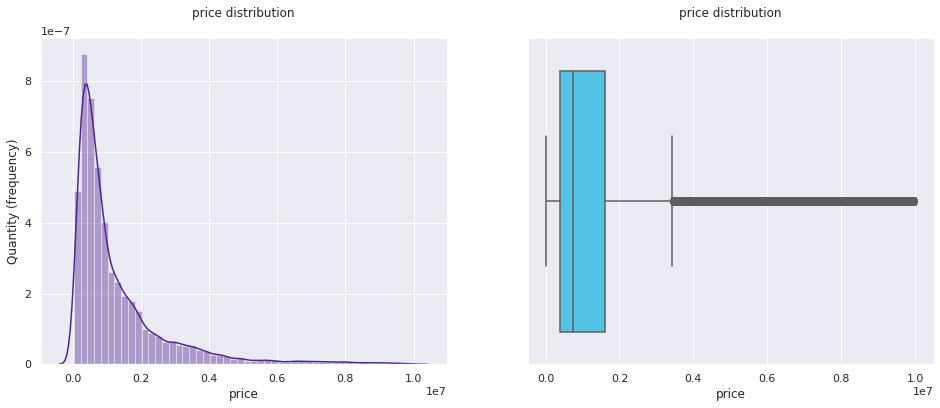

In [83]:
show_IQR(train.query("price < 10_000_000").price)

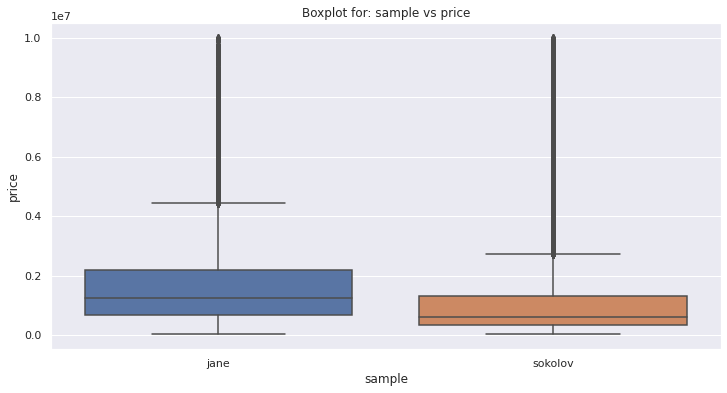

In [84]:
show_boxplots(train.query("price < 10_000_000"), "sample", "price")

## writing results to files

In [85]:
train.to_pickle("data/2022-04-05_train_preprocessed.pkl.zip", compression="zip")
test.to_pickle("data/2022-04-05_test_preprocessed.pkl.zip", compression="zip")

Next: [EDA](2022-03-31_train-test_EDA.ipynb)